# Import Libraries

In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Load Data

In [3]:
def load_data(path_DI, source):
    data = pd.read_csv(path_DI)
    if source:
        data = data[['Source','Polymers','Em(MPa)','Km(W/m.K)','vm','Romat', 'fl(LM)','Solids','Es(MPa)','Ks(W/m.K)','vs','Rosolid', 'fs(solid)','EffElasticMod(MPa)','EffThermCond(W/m.K)','EffDensity(g/m^3)']]
        column_map = {
            'Source':'data_source',
            'Polymers':'polymer_type',
            'Em(MPa)':'matrix_elastic_modulus',
            'Km(W/m.K)':'matrix_thermal_conductivity',
            'vm':'matrix_posson_ratio',
            'Romat':'matrix_density',
            'fl(LM)':'liquid_metal_fraction',
            'Solids':'solid_type',
            'Es(MPa)':'solid_elastic_modulus',
            'Ks(W/m.K)':'solid_thermal_conductivity',
            'vs':'solid_posson_ratio',
            'Rosolid':'solid_density',
            'fs(solid)':'solid_fraction',
            'EffElasticMod(MPa)':'composite_elastic_modulus',
            'EffThermCond(W/m.K)':'composite_thermal_conductivity',
            'EffDensity(g/m^3)':'composite_density'
        }
    else:
        data = data[['Polymers','Em(MPa)','Km(W/m.K)','vm','Romat', 'fl(LM)','Solids','Es(MPa)','Ks(W/m.K)','vs','Rosolid', 'fs(solid)','EffElasticMod(MPa)','EffThermCond(W/m.K)','EffDensity(g/m^3)']]
        column_map = {
            'Polymers':'polymer_type',
            'Em(MPa)':'matrix_elastic_modulus',
            'Km(W/m.K)':'matrix_thermal_conductivity',
            'vm':'matrix_posson_ratio',
            'Romat':'matrix_density',
            'fl(LM)':'liquid_metal_fraction',
            'Solids':'solid_type',
            'Es(MPa)':'solid_elastic_modulus',
            'Ks(W/m.K)':'solid_thermal_conductivity',
            'vs':'solid_posson_ratio',
            'Rosolid':'solid_density',
            'fs(solid)':'solid_fraction',
            'EffElasticMod(MPa)':'composite_elastic_modulus',
            'EffThermCond(W/m.K)':'composite_thermal_conductivity',
            'EffDensity(g/m^3)':'composite_density'
        }
    data.rename(columns=column_map, inplace=True)
    return data

# Split Data

In [4]:
source_ = False
path_DI = 'D:\Gitkraken\Second-HFC-ML-Sphere\Data generation and dataset\Dataset/combined dataset.csv'
df = load_data(path_DI, source=source_)

feature_cols = [
    'matrix_elastic_modulus', 
    'matrix_posson_ratio', 
    'matrix_thermal_conductivity', 
    'matrix_density',
    'solid_elastic_modulus', 
    'solid_posson_ratio', 
    'solid_thermal_conductivity', 
    'solid_density',
    'liquid_metal_fraction', 
    'solid_fraction'
]
target_cols = [
    'composite_elastic_modulus', 
    'composite_thermal_conductivity', 
    'composite_density'
]

X_raw = df[feature_cols].values  # shape (N,10)
Y_raw = df[target_cols].values   # shape (N,3)

print(f"Dataset shape: {X_raw.shape}, Targets shape: {Y_raw.shape}")

full_split_fraction = 0.8
train_df_ratio = 0.8
X_tv, X_test, Y_tv, Y_test = train_test_split(X_raw, Y_raw, test_size=1-full_split_fraction, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=1-train_df_ratio, random_state=42)

print("Train shape:", X_train.shape, Y_train.shape)
print("Val   shape:", X_val.shape,   Y_val.shape)
print("Test  shape:", X_test.shape,  Y_test.shape)

Dataset shape: (28600, 10), Targets shape: (28600, 3)
Train shape: (18304, 10) (18304, 3)
Val   shape: (4576, 10) (4576, 3)
Test  shape: (5720, 10) (5720, 3)


# Data Standarlization

In [5]:
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(Y_train)

X_train_scaled = scaler_x.transform(X_train)
X_val_scaled   = scaler_x.transform(X_val)
X_test_scaled  = scaler_x.transform(X_test)

Y_train_scaled = scaler_y.transform(Y_train)
Y_val_scaled   = scaler_y.transform(Y_val)
Y_test_scaled  = scaler_y.transform(Y_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test_scaled,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds   = TensorDataset(X_val_t,   Y_val_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

# Forward net define + training

In [6]:
class ForwardNet(nn.Module):
    def __init__(self, input_dim=10, output_dim=3):
        super(ForwardNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

forward_net = ForwardNet(input_dim=10, output_dim=3)
optimizer_fwd = optim.Adam(forward_net.parameters(), lr=1e-3)
criterion_fwd = nn.MSELoss()

In [7]:
train_losses = []
val_losses = []

epochs_fwd = 100
for epoch in range(epochs_fwd):
    forward_net.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer_fwd.zero_grad()
        y_pred = forward_net(x_batch)
        loss = criterion_fwd(y_pred, y_batch)
        loss.backward()
        optimizer_fwd.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)  
    
    forward_net.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val_b, y_val_b in val_loader:
            y_val_pred = forward_net(x_val_b)
            val_loss += criterion_fwd(y_val_pred, y_val_b).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  
    
    if (epoch+1) % 5 == 0:
        print(f"[ForwardNet] Epoch {epoch+1}/{epochs_fwd}, Train MSE={avg_train_loss:.4f}, Val MSE={avg_val_loss:.4f}")

[ForwardNet] Epoch 5/100, Train MSE=0.0118, Val MSE=0.0119
[ForwardNet] Epoch 10/100, Train MSE=0.0051, Val MSE=0.0054
[ForwardNet] Epoch 15/100, Train MSE=0.0031, Val MSE=0.0030
[ForwardNet] Epoch 20/100, Train MSE=0.0022, Val MSE=0.0026
[ForwardNet] Epoch 25/100, Train MSE=0.0018, Val MSE=0.0019
[ForwardNet] Epoch 30/100, Train MSE=0.0015, Val MSE=0.0019
[ForwardNet] Epoch 35/100, Train MSE=0.0015, Val MSE=0.0012
[ForwardNet] Epoch 40/100, Train MSE=0.0012, Val MSE=0.0010
[ForwardNet] Epoch 45/100, Train MSE=0.0010, Val MSE=0.0010
[ForwardNet] Epoch 50/100, Train MSE=0.0010, Val MSE=0.0009
[ForwardNet] Epoch 55/100, Train MSE=0.0009, Val MSE=0.0007
[ForwardNet] Epoch 60/100, Train MSE=0.0008, Val MSE=0.0009
[ForwardNet] Epoch 65/100, Train MSE=0.0007, Val MSE=0.0009
[ForwardNet] Epoch 70/100, Train MSE=0.0007, Val MSE=0.0006
[ForwardNet] Epoch 75/100, Train MSE=0.0006, Val MSE=0.0006
[ForwardNet] Epoch 80/100, Train MSE=0.0008, Val MSE=0.0010
[ForwardNet] Epoch 85/100, Train MSE=0.00

# Forward Net Visulization

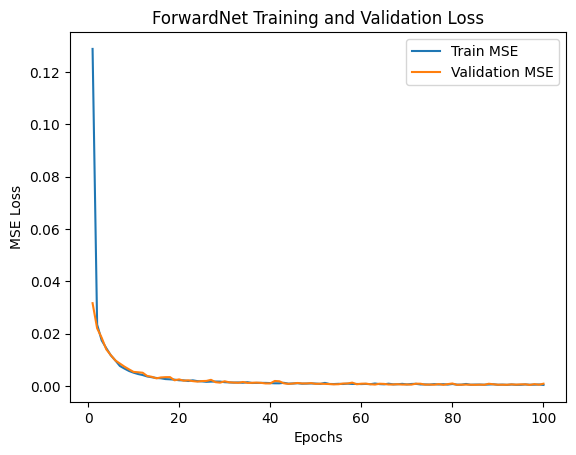

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs_fwd+1), train_losses, label='Train MSE')
plt.plot(range(1, epochs_fwd+1), val_losses, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('ForwardNet Training and Validation Loss')
plt.legend()
plt.show()

In [44]:
import pandas as pd

loss_data = {
    "Epoch": range(1, epochs_fwd + 1),
    "Train MSE Loss": train_losses,
    "Validation MSE Loss": val_losses
}

loss_df = pd.DataFrame(loss_data)

loss_df.to_csv("forward_net_training_validation_loss.csv", index=False)


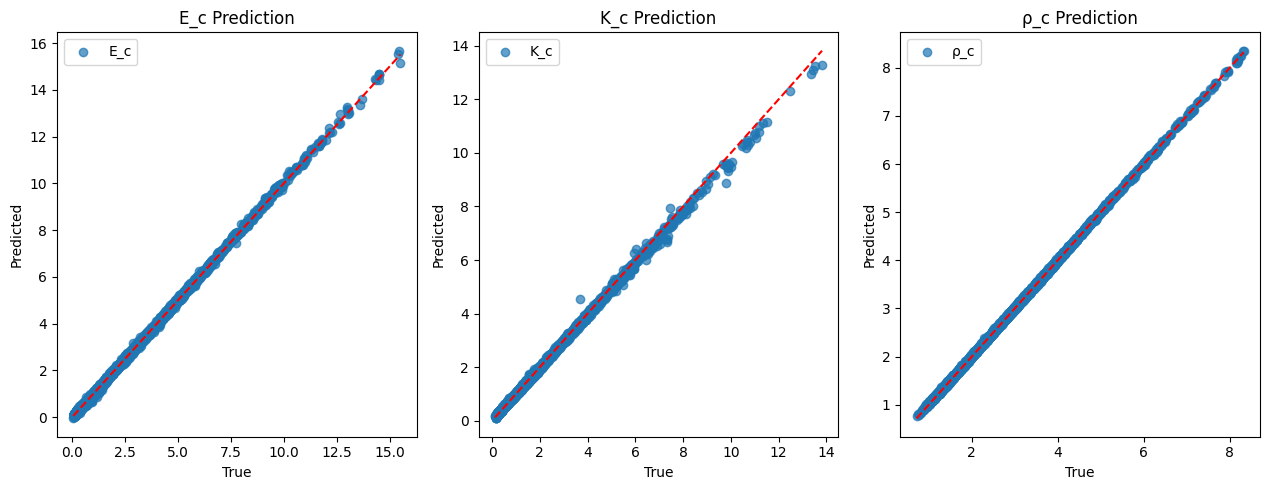

In [10]:
forward_net.eval()
with torch.no_grad():
    y_test_pred_scaled = forward_net(X_test_t).numpy()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_true = scaler_y.inverse_transform(Y_test_t.numpy())

plt.figure(figsize=(12.8, 5))
for i, target_name in enumerate(['E_c', 'K_c', 'ρ_c']):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_true[:, i], y_test_pred[:, i], alpha=0.7, label=target_name)
    plt.plot([y_test_true[:, i].min(), y_test_true[:, i].max()], 
             [y_test_true[:, i].min(), y_test_true[:, i].max()], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'{target_name} Prediction')
    plt.legend()
plt.tight_layout()
plt.show()


C:\Users\11213\AppData\Local\Temp\ipykernel_24064\597518574.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test_true[:, i].min(), y_test_true[:, i].max()],


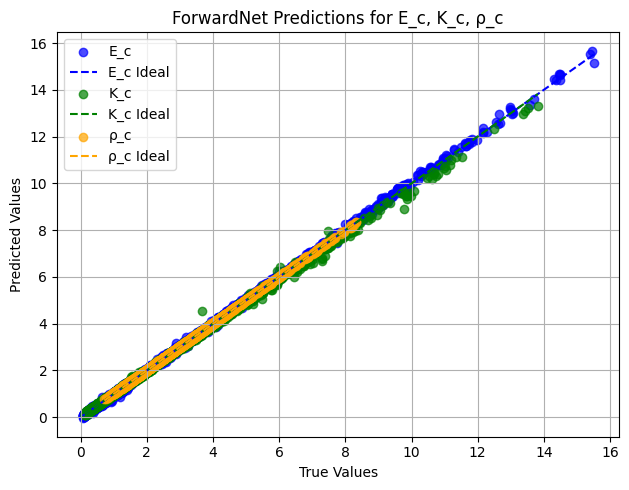

In [45]:
forward_net.eval()
with torch.no_grad():
    y_test_pred_scaled = forward_net(X_test_t).numpy()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_true = scaler_y.inverse_transform(Y_test_t.numpy())

plt.figure(figsize=(6.4, 5))
colors = ['blue', 'green', 'orange'] 
for i, (target_name, color) in enumerate(zip(['E_c', 'K_c', 'ρ_c'], colors)):
    plt.scatter(y_test_true[:, i], y_test_pred[:, i], alpha=0.7, label=target_name, color=color)
    plt.plot([y_test_true[:, i].min(), y_test_true[:, i].max()], 
             [y_test_true[:, i].min(), y_test_true[:, i].max()], 'r--', label=f'{target_name} Ideal', color=color)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('ForwardNet Predictions for E_c, K_c, ρ_c')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [46]:
import pandas as pd

prediction_data = {
    "True E_c": y_test_true[:, 0],
    "Predicted E_c": y_test_pred[:, 0],
    "True K_c": y_test_true[:, 1],
    "Predicted K_c": y_test_pred[:, 1],
    "True ρ_c": y_test_true[:, 2],
    "Predicted ρ_c": y_test_pred[:, 2]
}

prediction_df = pd.DataFrame(prediction_data)

prediction_df.to_csv("true_vs_predicted_forward_net.csv", index=False)


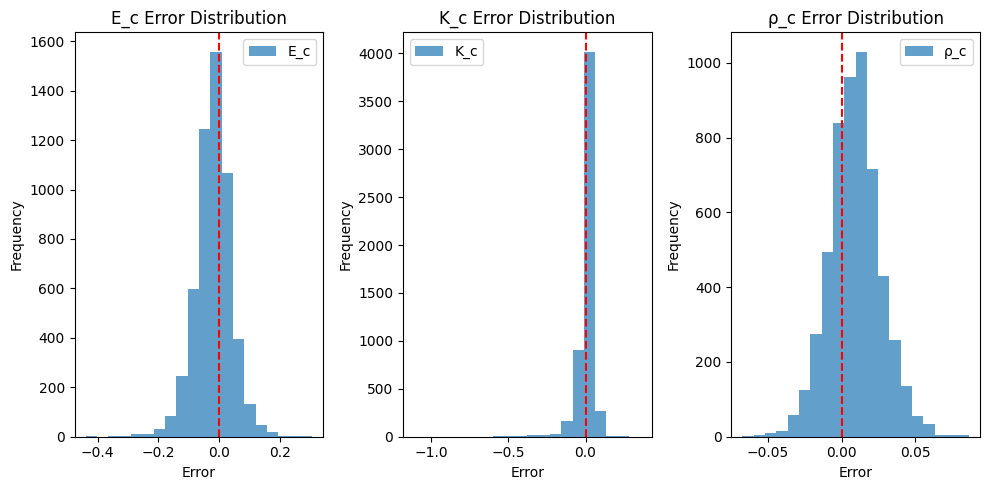

In [10]:
errors = y_test_true - y_test_pred

plt.figure(figsize=(10, 5))
for i, target_name in enumerate(['E_c', 'K_c', 'ρ_c']):
    plt.subplot(1, 3, i+1)
    plt.hist(errors[:, i], bins=20, alpha=0.7, label=target_name)
    plt.axvline(0, color='red', linestyle='--')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(f'{target_name} Error Distribution')
    plt.legend()
plt.tight_layout()
plt.show()


# cVAE model (Encoder for (x,y) to z, Decoder for (z,y) to x)

In [9]:
class ConditionalVAE(nn.Module):
    def __init__(self, x_dim=10, y_dim=3, latent_dim=5):
        super(ConditionalVAE, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.latent_dim = latent_dim
        
        # Encoder: x_dim + y_dim
        self.encoder = nn.Sequential(
            nn.Linear(x_dim + y_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        
        # Decoder: latent_dim + y_dim
        self.fc1 = nn.Linear(latent_dim + y_dim, 32)
        self.fc2 = nn.Linear(32 + y_dim, 64)  # introduce y
        self.fc3 = nn.Linear(64, x_dim)
        self.activation = nn.ReLU()
    
    def encode(self, x, y):
        xy = torch.cat([x, y], dim=1) 
        h = self.encoder(xy)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        h1 = self.activation(self.fc1(zy))
        h2 = torch.cat([h1, y], dim=1)  # introduce y
        h2 = self.activation(self.fc2(h2))
        return self.fc3(h2)
    
    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar


# Define Loss function

In [10]:
def cvae_loss_function(x, x_recon, mu, logvar):
    beta=0.1
    recon_loss = nn.MSELoss(reduction='sum')(x_recon, x)  
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta  
    return recon_loss, kl_loss, recon_loss + kl_loss

# VAE model training

In [11]:

cvae = ConditionalVAE(x_dim=len(feature_cols), y_dim=len(target_cols), latent_dim=5)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=1e-3)

epochs_cvae = 100
losses_recon = []  
losses_kl = []  
losses_total = []  

for epoch in range(epochs_cvae):
    cvae.train()
    total_loss_c = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer_cvae.zero_grad()
        x_recon, mu, logvar = cvae(x_batch, y_batch)
        recon_loss, kl_loss, total_loss = cvae_loss_function(x_batch, x_recon, mu, logvar)
        total_loss.backward()
        optimizer_cvae.step()

        total_loss_c += total_loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    avg_total_loss = total_loss_c / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_kl_loss = total_kl_loss / len(train_loader)

    losses_recon.append(avg_recon_loss)
    losses_kl.append(avg_kl_loss)
    losses_total.append(avg_total_loss)

    if (epoch + 1) % 5 == 0:
        print(f"[cVAE] Epoch {epoch + 1}/{epochs_cvae}, Total Loss={avg_total_loss:.2f}, Recon Loss={avg_recon_loss:.2f}, KL Loss={avg_kl_loss:.2f}")


[cVAE] Epoch 5/100, Total Loss=36.52, Recon Loss=13.30, KL Loss=23.22
[cVAE] Epoch 10/100, Total Loss=33.45, Recon Loss=11.35, KL Loss=22.10
[cVAE] Epoch 15/100, Total Loss=31.73, Recon Loss=10.42, KL Loss=21.31
[cVAE] Epoch 20/100, Total Loss=30.71, Recon Loss=9.90, KL Loss=20.80
[cVAE] Epoch 25/100, Total Loss=29.93, Recon Loss=9.41, KL Loss=20.52
[cVAE] Epoch 30/100, Total Loss=29.60, Recon Loss=9.22, KL Loss=20.38
[cVAE] Epoch 35/100, Total Loss=29.04, Recon Loss=8.93, KL Loss=20.11
[cVAE] Epoch 40/100, Total Loss=28.77, Recon Loss=8.80, KL Loss=19.97
[cVAE] Epoch 45/100, Total Loss=28.38, Recon Loss=8.61, KL Loss=19.77
[cVAE] Epoch 50/100, Total Loss=28.24, Recon Loss=8.47, KL Loss=19.77
[cVAE] Epoch 55/100, Total Loss=28.01, Recon Loss=8.42, KL Loss=19.60
[cVAE] Epoch 60/100, Total Loss=27.73, Recon Loss=8.30, KL Loss=19.43
[cVAE] Epoch 65/100, Total Loss=27.65, Recon Loss=8.23, KL Loss=19.42
[cVAE] Epoch 70/100, Total Loss=27.47, Recon Loss=8.14, KL Loss=19.33
[cVAE] Epoch 75/10

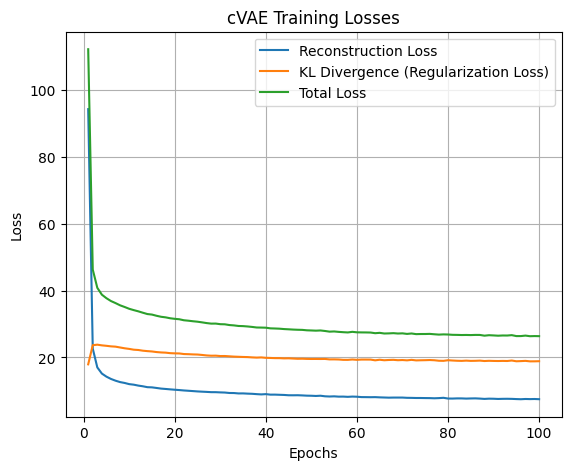

In [14]:
plt.figure(figsize=(6.4, 5))
plt.plot(range(1, epochs_cvae + 1), losses_recon, label='Reconstruction Loss')
plt.plot(range(1, epochs_cvae + 1), losses_kl, label='KL Divergence (Regularization Loss)')
plt.plot(range(1, epochs_cvae + 1), losses_total, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('cVAE Training Losses')
plt.legend()
plt.grid()
plt.show()

In [29]:
import pandas as pd

loss_data = {
    "Epoch": range(1, epochs_cvae + 1),
    "Reconstruction Loss": losses_recon,
    "KL Divergence": losses_kl,
    "Total Loss": losses_total
}

loss_df = pd.DataFrame(loss_data)

loss_df.to_csv("cvae_training_losses.csv", index=False)


# VAE model visulization

Latent space

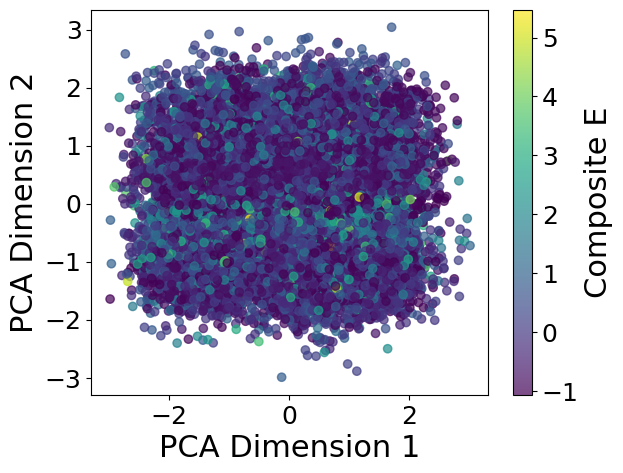

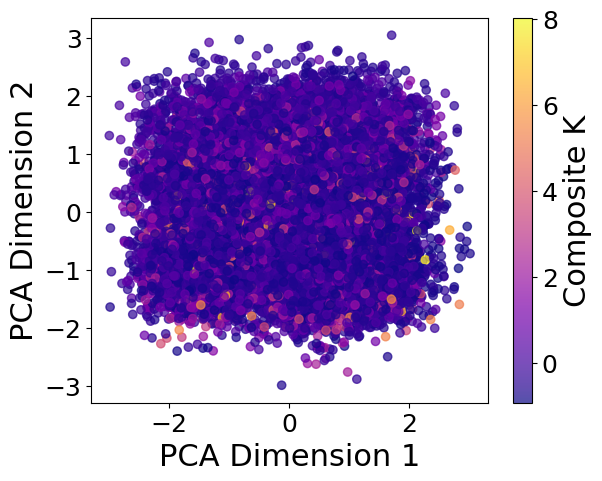

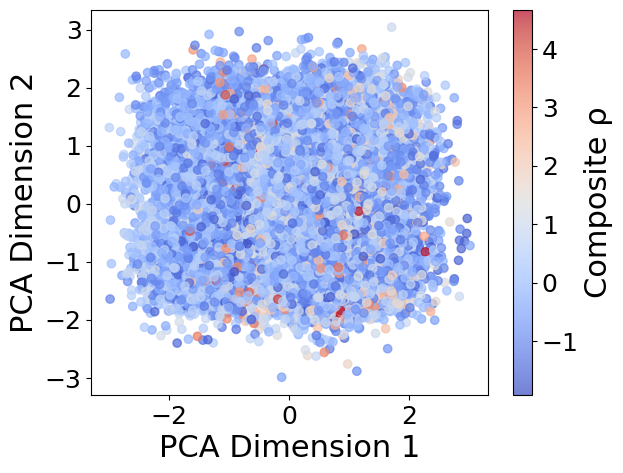

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

z_samples = []  
y_labels = []   
for x_batch, y_batch in train_loader:
    mu, logvar = cvae.encode(x_batch, y_batch)
    z = cvae.reparameterize(mu, logvar)
    z_samples.append(z.detach().numpy())
    y_labels.append(y_batch.numpy())

z_samples = np.concatenate(z_samples, axis=0)  
y_labels = np.concatenate(y_labels, axis=0)   

# PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z_samples)

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6.4, 5))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_labels[:, 0], cmap='viridis', alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Composite E', fontsize=22)
cbar.ax.tick_params(labelsize=18) 

plt.xlabel('PCA Dimension 1', fontsize=22)
plt.ylabel('PCA Dimension 2', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Latent Space Visualization', fontsize=18)
plt.show()


#plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6.4, 5))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_labels[:, 1], cmap='plasma', alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Composite K', fontsize=22)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('PCA Dimension 1', fontsize=22)
plt.ylabel('PCA Dimension 2', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Latent Space Visualization (Condition: K_c)', fontsize=22)
plt.show()

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6.4, 5))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_labels[:, 2], cmap='coolwarm', alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Composite ρ', fontsize=22) 
cbar.ax.tick_params(labelsize=18)
plt.xlabel('PCA Dimension 1', fontsize=22)
plt.ylabel('PCA Dimension 2', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Latent Space Visualization (Condition: σ_c)', fontsize=22)
plt.show()


In [31]:
import pandas as pd

pca_data = {
    "PCA Dimension 1": z_2d[:, 0],
    "PCA Dimension 2": z_2d[:, 1],
    "E_c": y_labels[:, 0],
    "K_c": y_labels[:, 1],
    "ρ_c": y_labels[:, 2]
}

pca_df = pd.DataFrame(pca_data)

pca_df.to_csv("latent_space_pca.csv", index=False)


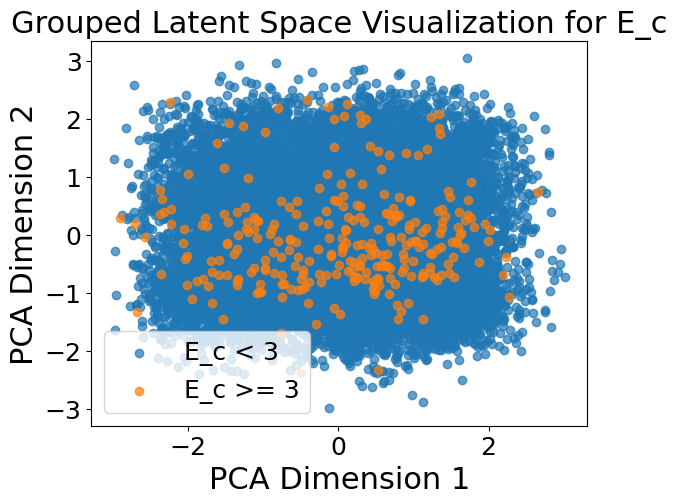

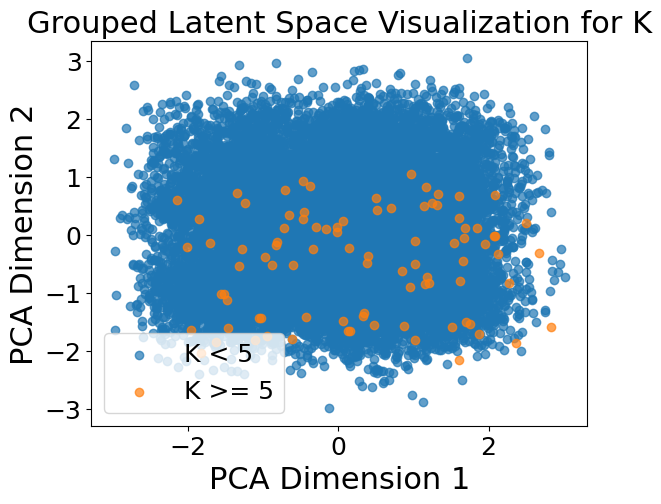

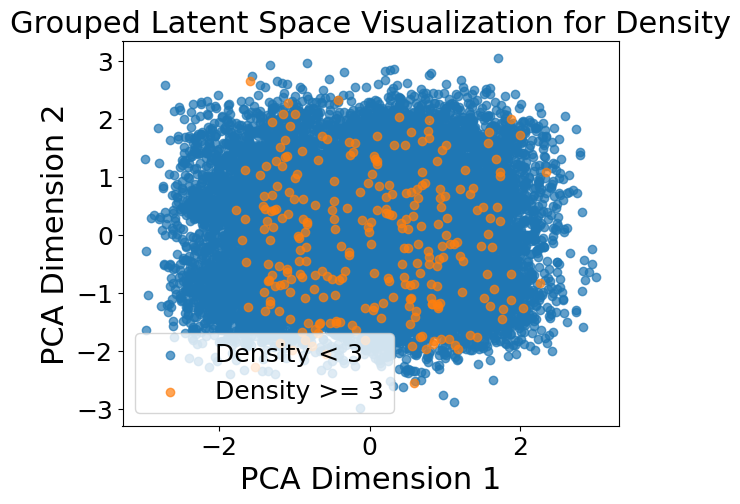

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Thresholds
threshold_Ec = 3
threshold_K = 5
threshold_density = 3

#groups based on thresholds
group_Ec_low = z_2d[y_labels[:, 0] < threshold_Ec]
group_Ec_high = z_2d[y_labels[:, 0] >= threshold_Ec]
group_K_low = z_2d[y_labels[:, 1] < threshold_K]
group_K_high = z_2d[y_labels[:, 1] >= threshold_K]
group_density_low = z_2d[y_labels[:, 2] < threshold_density]
group_density_high = z_2d[y_labels[:, 2] >= threshold_density]

#E_c
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6.4, 5))
plt.scatter(group_Ec_low[:, 0], group_Ec_low[:, 1], label=f'E_c < {threshold_Ec}', alpha=0.7)
plt.scatter(group_Ec_high[:, 0], group_Ec_high[:, 1], label=f'E_c >= {threshold_Ec}', alpha=0.7)
plt.legend(fontsize=18)
plt.xlabel('PCA Dimension 1', fontsize=22)
plt.ylabel('PCA Dimension 2', fontsize=22)
plt.title('Grouped Latent Space Visualization for E_c', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Plot for K
plt.figure(figsize=(6.4, 5))
plt.scatter(group_K_low[:, 0], group_K_low[:, 1], label=f'K < {threshold_K}', alpha=0.7)
plt.scatter(group_K_high[:, 0], group_K_high[:, 1], label=f'K >= {threshold_K}', alpha=0.7)
plt.legend(fontsize=18)
plt.xlabel('PCA Dimension 1', fontsize=22)
plt.ylabel('PCA Dimension 2', fontsize=22)
plt.title('Grouped Latent Space Visualization for K', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

#Density
plt.figure(figsize=(6.4, 5))
plt.scatter(group_density_low[:, 0], group_density_low[:, 1], label=f'Density < {threshold_density}', alpha=0.7)
plt.scatter(group_density_high[:, 0], group_density_high[:, 1], label=f'Density >= {threshold_density}', alpha=0.7)
plt.legend(fontsize=18)
plt.xlabel('PCA Dimension 1', fontsize=22)
plt.ylabel('PCA Dimension 2', fontsize=22)
plt.title('Grouped Latent Space Visualization for Density', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

group_Ec_low_data = pd.DataFrame({
    "PCA Dimension 1": group_Ec_low[:, 0],
    "PCA Dimension 2": group_Ec_low[:, 1],
    "Group": f"E_c < {threshold_Ec}"
})

group_Ec_high_data = pd.DataFrame({
    "PCA Dimension 1": group_Ec_high[:, 0],
    "PCA Dimension 2": group_Ec_high[:, 1],
    "Group": f"E_c >= {threshold_Ec}"
})

group_K_low_data = pd.DataFrame({
    "PCA Dimension 1": group_K_low[:, 0],
    "PCA Dimension 2": group_K_low[:, 1],
    "Group": f"K < {threshold_K}"
})

group_K_high_data = pd.DataFrame({
    "PCA Dimension 1": group_K_high[:, 0],
    "PCA Dimension 2": group_K_high[:, 1],
    "Group": f"K >= {threshold_K}"
})

group_density_low_data = pd.DataFrame({
    "PCA Dimension 1": group_density_low[:, 0],
    "PCA Dimension 2": group_density_low[:, 1],
    "Group": f"Density < {threshold_density}"
})

group_density_high_data = pd.DataFrame({
    "PCA Dimension 1": group_density_high[:, 0],
    "PCA Dimension 2": group_density_high[:, 1],
    "Group": f"Density >= {threshold_density}"
})

grouped_Ec_data = pd.concat([group_Ec_low_data, group_Ec_high_data])
grouped_Ec_data.to_csv("grouped_latent_space_Ec.csv", index=False)

grouped_K_data = pd.concat([group_K_low_data, group_K_high_data])
grouped_K_data.to_csv("grouped_latent_space_K.csv", index=False)

grouped_density_data = pd.concat([group_density_low_data, group_density_high_data])
grouped_density_data.to_csv("grouped_latent_space_density.csv", index=False)

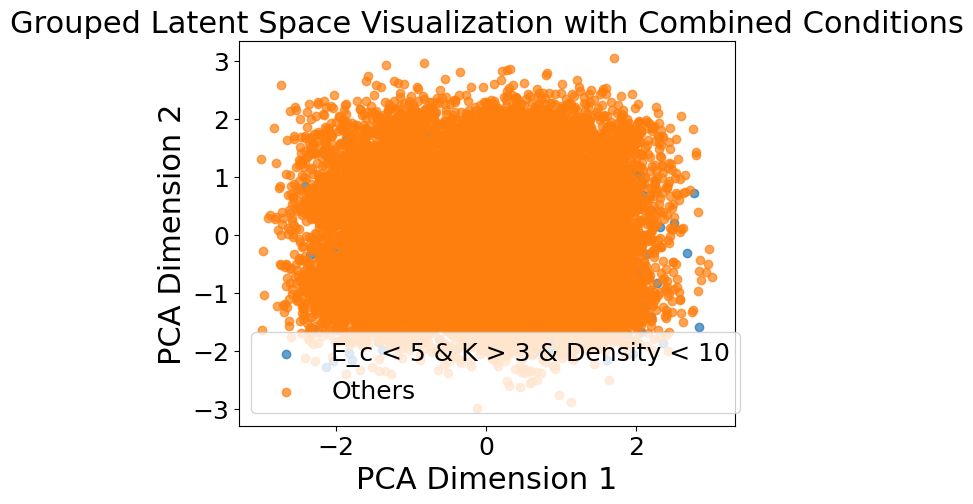

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

threshold_Ec = 5
threshold_K = 3
threshold_density = 10

group_combined = z_2d[(y_labels[:, 0] < threshold_Ec) & 
                      (y_labels[:, 1] > threshold_K) & 
                      (y_labels[:, 2] < threshold_density)]
group_others = z_2d[~((y_labels[:, 0] < threshold_Ec) & 
                      (y_labels[:, 1] > threshold_K) & 
                      (y_labels[:, 2] < threshold_density))]


plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6.4, 5))
plt.scatter(group_combined[:, 0], group_combined[:, 1], label=f'E_c < {threshold_Ec} & K > {threshold_K} & Density < {threshold_density}', alpha=0.7)
plt.scatter(group_others[:, 0], group_others[:, 1], label='Others', alpha=0.7)
plt.legend(fontsize=18)
plt.xlabel('PCA Dimension 1', fontsize=22)
plt.ylabel('PCA Dimension 2', fontsize=22)
plt.title('Grouped Latent Space Visualization with Combined Conditions', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

group_combined_data = pd.DataFrame({
    "PCA Dimension 1": group_combined[:, 0],
    "PCA Dimension 2": group_combined[:, 1],
    "Group": f"E_c < {threshold_Ec} & K > {threshold_K} & Density < {threshold_density}"
})

group_others_data = pd.DataFrame({
    "PCA Dimension 1": group_others[:, 0],
    "PCA Dimension 2": group_others[:, 1],
    "Group": "Others"
})

grouped_combined_data = pd.concat([group_combined_data, group_others_data])
grouped_combined_data.to_csv("grouped_latent_space_combined.csv", index=False)


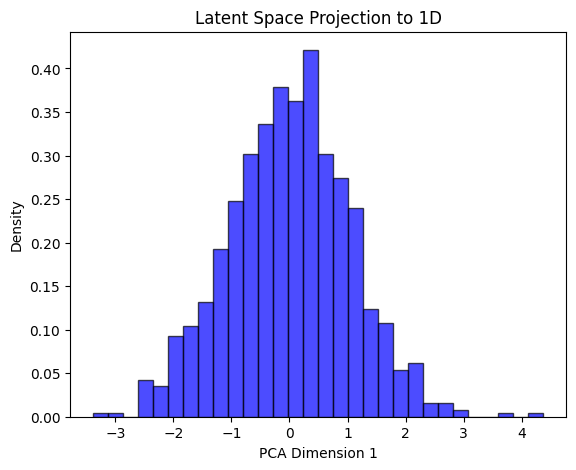

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

z_samples = np.random.normal(0, 1, size=(1000, 5)) 

pca = PCA(n_components=1)
z_1d = pca.fit_transform(z_samples).flatten()  

plt.figure(figsize=(6.4, 5))
plt.hist(z_1d, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Latent Space Projection to 1D')
plt.xlabel('PCA Dimension 1')
plt.ylabel('Density')
plt.show()


In [34]:
import pandas as pd

pca_1d_data = pd.DataFrame({
    "PCA Dimension 1": z_1d
})

pca_1d_data.to_csv("latent_space_1d_projection.csv", index=False)


reconstruction evaluation

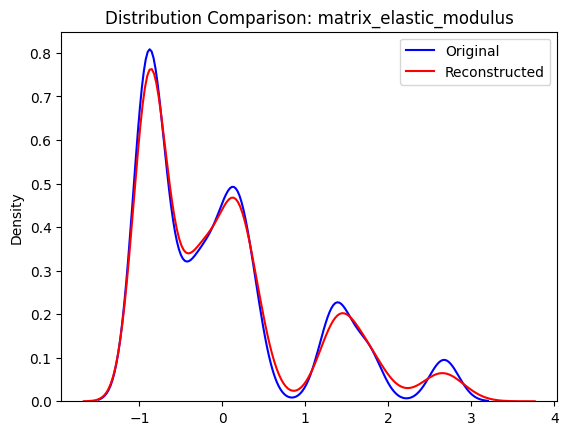

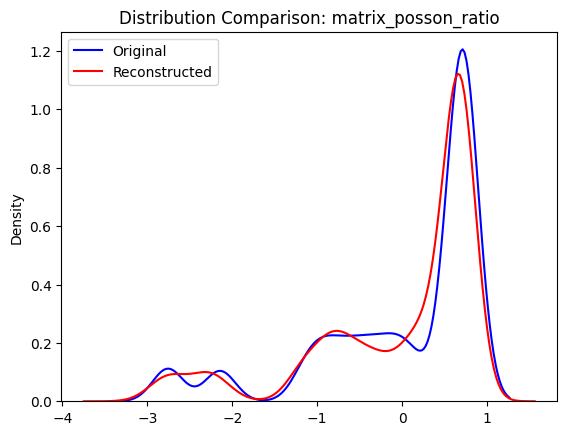

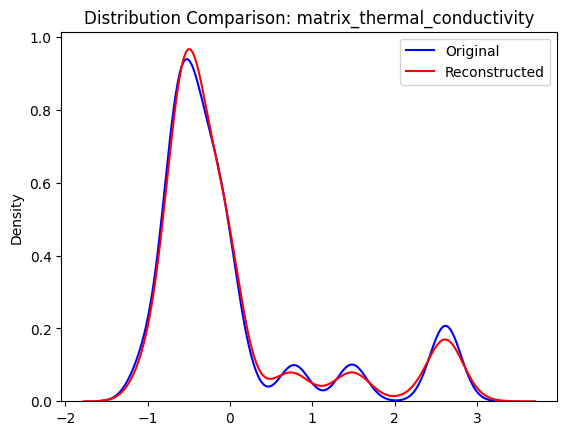

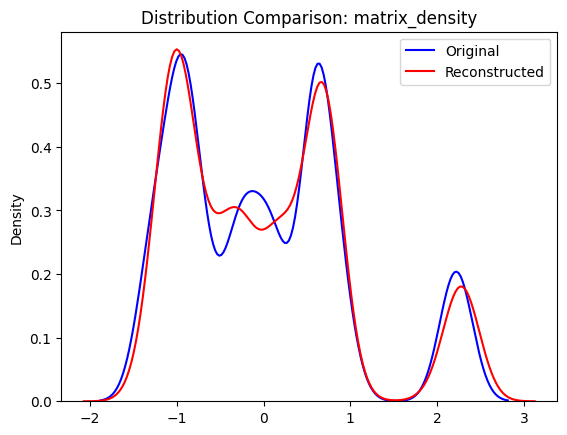

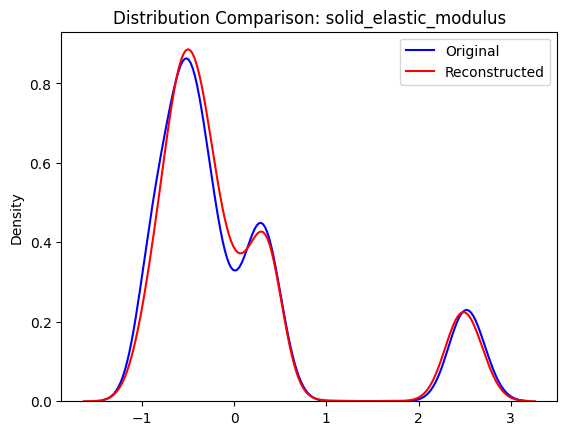

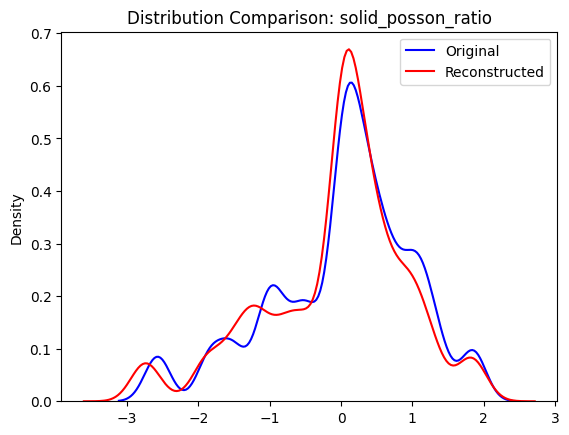

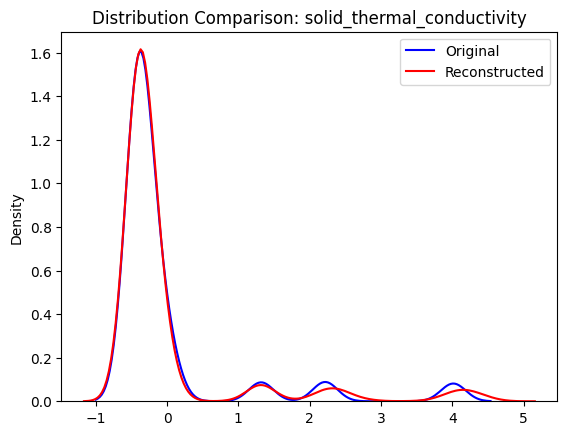

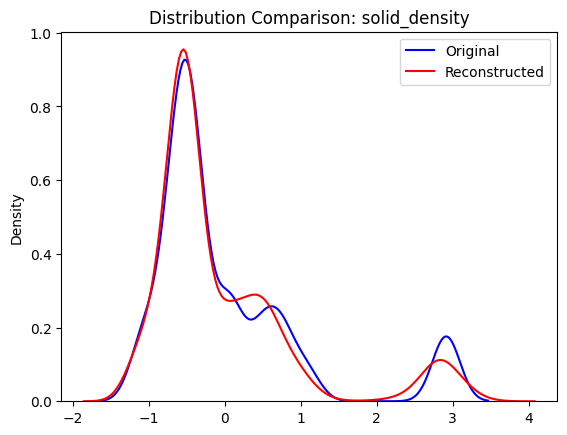

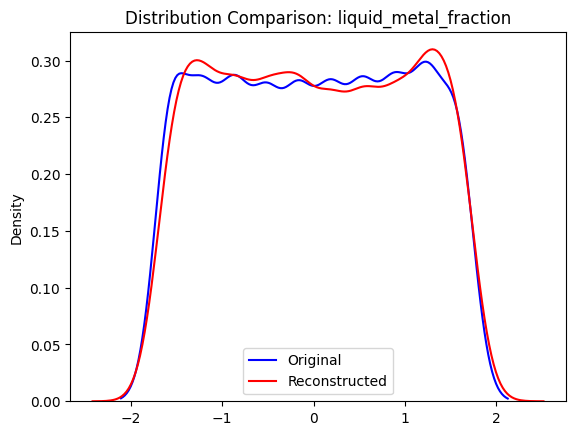

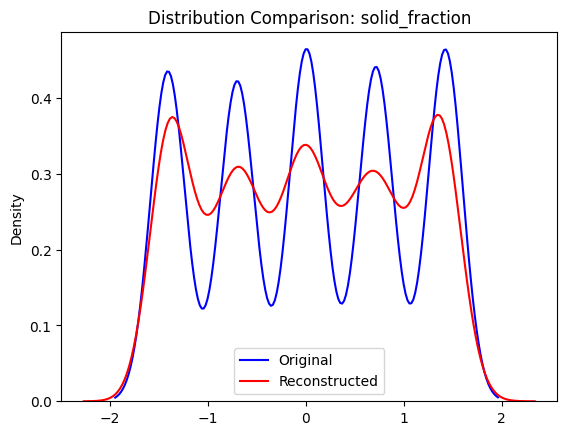

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

x = X_test_scaled  
y = Y_test_scaled  

cvae.eval()  
with torch.no_grad():
    x_torch = torch.tensor(x, dtype=torch.float32)  
    y_torch = torch.tensor(y, dtype=torch.float32)  
    x_recon_torch, _, _ = cvae(x_torch, y_torch)    
    x_recon = x_recon_torch.numpy()               

assert len(feature_cols) == x.shape[1] == x_recon.shape[1], "Feature dimensions mismatch!"


for i, feature in enumerate(feature_cols):
    plt.figure()
    sns.kdeplot(x[:, i], label='Original', color='blue')     
    sns.kdeplot(x_recon[:, i], label='Reconstructed', color='red')  
    plt.title(f'Distribution Comparison: {feature}')
    plt.legend()
    plt.show()


In [ ]:
from scipy import stats

all_distributions = []

for i, feature in enumerate(feature_cols):
    min_val = min(np.min(x[:, i]), np.min(x_recon[:, i]))
    max_val = max(np.max(x[:, i]), np.max(x_recon[:, i]))
    support = np.linspace(min_val, max_val, 200)  
    
    kde_original = stats.gaussian_kde(x[:, i])
    density_original = kde_original(support)

    kde_recon = stats.gaussian_kde(x_recon[:, i])
    density_recon = kde_recon(support)
    
    feature_df = pd.DataFrame({
        f"{feature}_Support": support,
        f"{feature}_Original_Density": density_original,
        f"{feature}_Reconstructed_Density": density_recon
    })
    
    all_distributions.append(feature_df)
final_df = pd.concat(all_distributions, axis=1)
final_df.to_csv("distribution_comparison.csv", index=False)

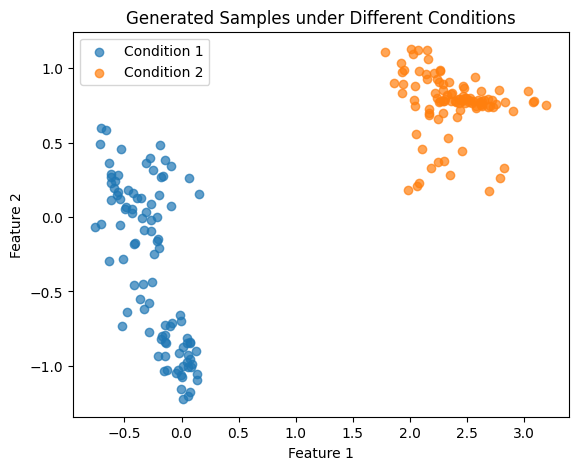

In [39]:
latent_dim = 5
conditions = [[2, 2, 2], [10, 10, 10]]  
all_generated_data = []

plt.figure(figsize=(6.4, 5))
for i, condition in enumerate(conditions):
    y_cond = scaler_y.transform([condition])  

    z_samples = torch.randn((100, latent_dim))  
    y_torch = torch.tensor(y_cond, dtype=torch.float32).repeat(100, 1)  # repeat 100 times
    x_generated = cvae.decode(z_samples, y_torch).detach().numpy()

    condition_label = [f'Condition {i+1}'] * len(x_generated)
    condition_data = pd.DataFrame(x_generated, columns=[f'Feature {j+1}' for j in range(x_generated.shape[1])])
    condition_data['Condition'] = condition_label
    all_generated_data.append(condition_data)

    plt.scatter(x_generated[:, 0], x_generated[:, 1], label=f'Condition {i+1}', alpha=0.7)

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Samples under Different Conditions')
plt.show()

final_data = pd.concat(all_generated_data, ignore_index=True)
final_data.to_csv("generated_samples_conditions.csv", index=False)


Show the ability to beyond the design space

PCA Component 1 explains 22.87% variance.
PCA Component 2 explains 21.67% variance.
Total explained variance by first 2 components: 44.54%


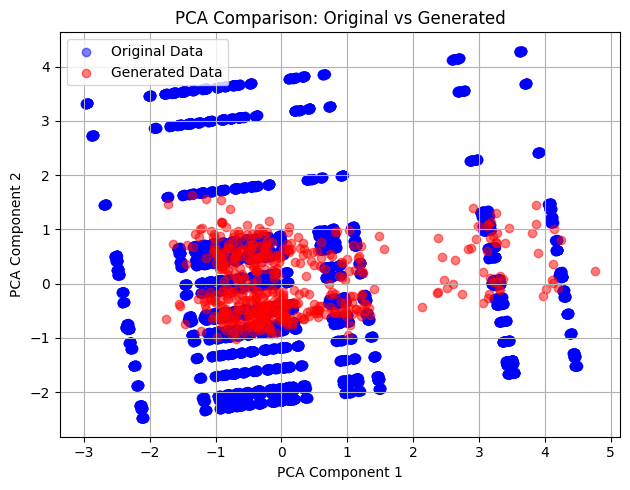

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA


original_data = X_train_scaled

cvae.eval()
n_samples = 500
latent_dim = cvae.latent_dim
z_random = torch.randn((n_samples, latent_dim))

# Condition
y_dim = cvae.y_dim
y_condition = torch.zeros((n_samples, y_dim), dtype=torch.float32)

with torch.no_grad():
    x_gen_torch = cvae.decode(z_random, y_condition)
    generated_data = x_gen_torch.detach().numpy()  

#PCA analysis
pca = PCA(n_components=2)
pca.fit(original_data)
original_pca = pca.transform(original_data)
generated_pca = pca.transform(generated_data)
var_ratio = pca.explained_variance_ratio_
print(f"PCA Component 1 explains {var_ratio[0]*100:.2f}% variance.")
print(f"PCA Component 2 explains {var_ratio[1]*100:.2f}% variance.")
print(f"Total explained variance by first 2 components: {sum(var_ratio)*100:.2f}%")

# Plotting comparison
plt.figure(figsize=(6.4, 5))
plt.scatter(original_pca[:, 0], original_pca[:, 1],
            color='blue', alpha=0.5, label='Original Data')

plt.scatter(generated_pca[:, 0], generated_pca[:, 1],
            color='red', alpha=0.5, label='Generated Data')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Comparison: Original vs Generated')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Original data shape: (18304, 10)
[PCA Info] Explained variance ratio: [0.22872384]


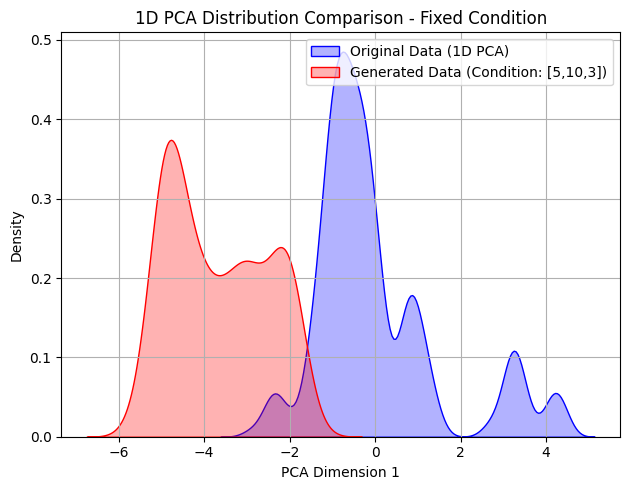

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

original_data = X_train_scaled  # shape (N, x_dim)
print("Original data shape:", original_data.shape)

pca_1d = PCA(n_components=1)
pca_1d.fit(original_data)
original_1d = pca_1d.transform(original_data).flatten()
print(f"[PCA Info] Explained variance ratio: {pca_1d.explained_variance_ratio_}")

cvae.eval()
n_samples = 500
latent_dim = cvae.latent_dim

fixed_condition = np.array([[20.0, 20.0, 20.0]])  # shape (1, y_dim)
fixed_condition_scaled = scaler_y.transform(fixed_condition)

z_random = torch.randn((n_samples, latent_dim))

fixed_y = torch.tensor(fixed_condition_scaled, dtype=torch.float32)
fixed_y_repeated = fixed_y.repeat(n_samples, 1)  

with torch.no_grad():
    x_gen_torch = cvae.decode(z_random, fixed_y_repeated)
    x_gen = x_gen_torch.detach().numpy()  # (n_samples, x_dim)

generated_1d = pca_1d.transform(x_gen).flatten()

plt.figure(figsize=(6.4, 5))
sns.kdeplot(original_1d, label='Original Data (1D PCA)', color='blue', fill=True, alpha=0.3)
sns.kdeplot(generated_1d, label='Generated Data (Condition: [5,10,3])', color='red', fill=True, alpha=0.3)

plt.xlabel('PCA Dimension 1')
plt.ylabel('Density')
plt.title('1D PCA Distribution Comparison - Fixed Condition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
df_export = pd.DataFrame({
    "Original_1D": original_1d,
    "Generated_1D": np.pad(generated_1d, (0, max(0, len(original_1d)-len(generated_1d))), 
                           mode='constant', constant_values=np.nan)
})

df_export.to_csv("pca_1d_distribution_comparison.csv", index=False)

prediction of reconstruction vs target

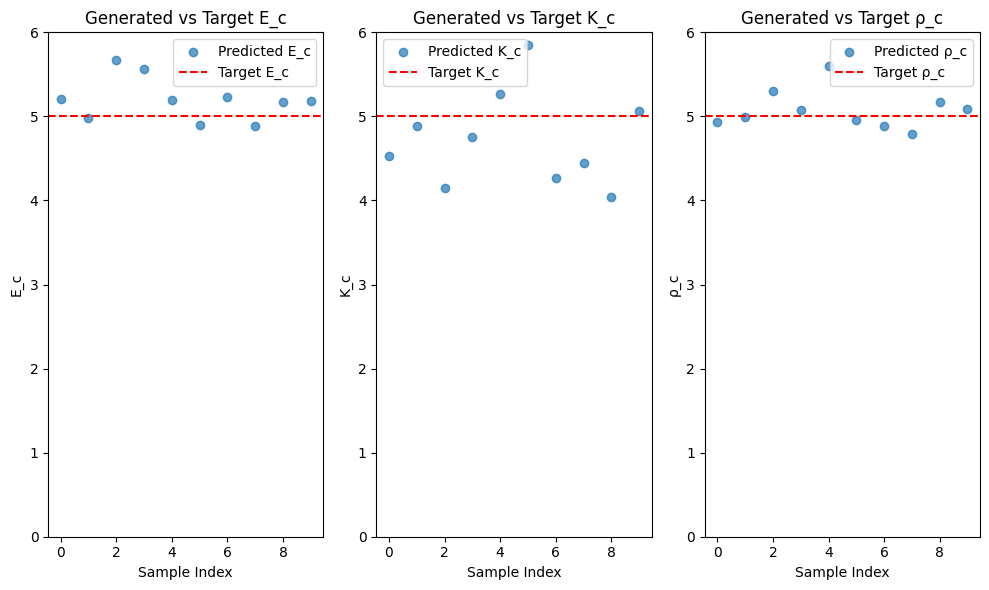

Sample 1:
  Predicted E_c=5.2121, K_c=4.5322, ρ_c=4.9331
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 2:
  Predicted E_c=4.9834, K_c=4.8847, ρ_c=4.9926
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 3:
  Predicted E_c=5.6659, K_c=4.1525, ρ_c=5.3022
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 4:
  Predicted E_c=5.5583, K_c=4.7493, ρ_c=5.0810
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 5:
  Predicted E_c=5.1900, K_c=5.2704, ρ_c=5.6046
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 6:
  Predicted E_c=4.9035, K_c=5.8472, ρ_c=4.9586
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 7:
  Predicted E_c=5.2310, K_c=4.2727, ρ_c=4.8917
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 8:
  Predicted E_c=4.8867, K_c=4.4427, ρ_c=4.7902
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 9:
  Predicted E_c=5.1703, K_c=4.0377, ρ_c=5.1757
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 10:
  Predicted E_c=5.1802, K_c=5.0685, ρ_c=5.08

In [18]:
cvae.eval()
forward_net.eval()

if 'scaler_y' not in locals():
    scaler_y = StandardScaler().fit(Y_train)

y_target = np.array([[5, 5, 5]])  
y_target_scaled = scaler_y.transform(y_target)  

latent_dim = 5 
z_random = torch.randn((10, latent_dim))  

y_target_torch = torch.tensor(y_target_scaled, dtype=torch.float32)
y_repeated = y_target_torch.repeat(z_random.size(0), 1)  
x_generated = cvae.decode(z_random, y_repeated)

y_pred_scaled = forward_net(x_generated).detach().numpy()
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(10, 6))
target_names = ['E_c', 'K_c', 'ρ_c']  

for i, target_name in enumerate(target_names):
    plt.subplot(1, 3, i + 1) 
    plt.scatter(range(len(y_pred_unscaled)), y_pred_unscaled[:, i], label=f'Predicted {target_name}', alpha=0.7)
    plt.axhline(y=y_target[0, i], color='red', linestyle='--', label=f'Target {target_name}')  
    plt.xlabel('Sample Index')
    plt.ylabel(target_name)
    plt.ylim(0,6)
    plt.legend()
    plt.title(f'Generated vs Target {target_name}')

plt.tight_layout() 
plt.show()

for i, pred in enumerate(y_pred_unscaled):
    print(f"Sample {i+1}:")
    print(f"  Predicted E_c={pred[0]:.4f}, K_c={pred[1]:.4f}, ρ_c={pred[2]:.4f}")
    print(f"  Target     E_c={y_target[0, 0]:.4f}, K_c={y_target[0, 1]:.4f}, ρ_c={y_target[0, 2]:.4f}")

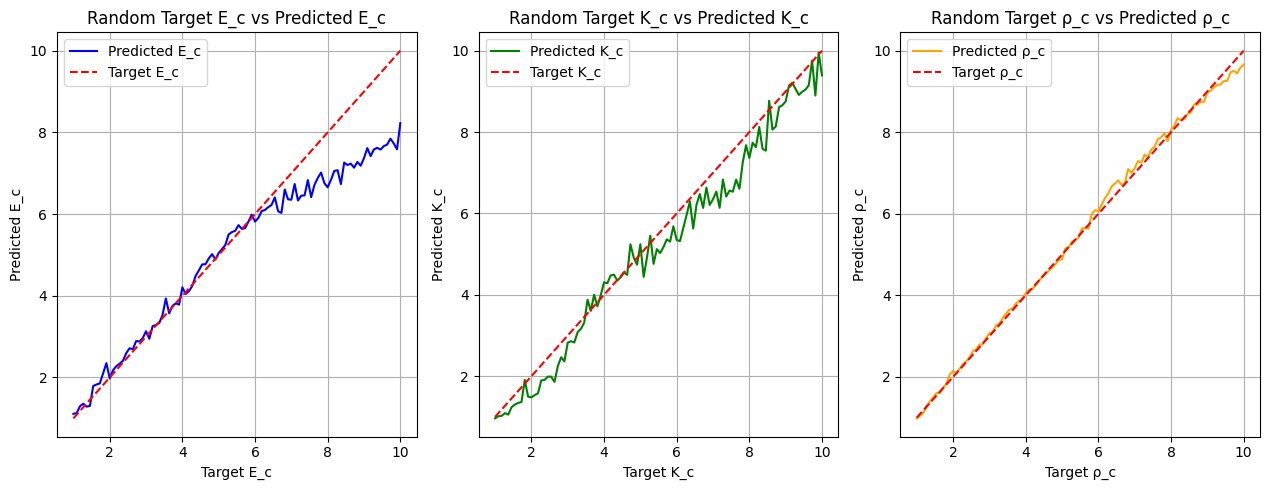

Sample Results:
Target: E_c=1.00, K_c=1.00, ρ_c=1.00
Predicted: E_c=1.11, K_c=0.96, ρ_c=0.98

Target: E_c=1.91, K_c=1.91, ρ_c=1.91
Predicted: E_c=2.35, K_c=1.50, ρ_c=2.06

Target: E_c=2.82, K_c=2.82, ρ_c=2.82
Predicted: E_c=2.88, K_c=2.46, ρ_c=2.80

Target: E_c=3.73, K_c=3.73, ρ_c=3.73
Predicted: E_c=3.75, K_c=4.00, ρ_c=3.80

Target: E_c=4.64, K_c=4.64, ρ_c=4.64
Predicted: E_c=4.77, K_c=4.49, ρ_c=4.60

Target: E_c=5.55, K_c=5.55, ρ_c=5.55
Predicted: E_c=5.73, K_c=5.03, ρ_c=5.64

Target: E_c=6.45, K_c=6.45, ρ_c=6.45
Predicted: E_c=6.22, K_c=5.63, ρ_c=6.74

Target: E_c=7.36, K_c=7.36, ρ_c=7.36
Predicted: E_c=6.46, K_c=6.42, ρ_c=7.39

Target: E_c=8.27, K_c=8.27, ρ_c=8.27
Predicted: E_c=7.08, K_c=8.13, ρ_c=8.30

Target: E_c=9.18, K_c=9.18, ρ_c=9.18
Predicted: E_c=7.42, K_c=9.21, ρ_c=9.10



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler

cvae.eval()
forward_net.eval()

if 'scaler_y' not in locals():
    scaler_y = StandardScaler().fit(Y_train)

n_samples = 100
e_c_targets = np.linspace(1, 10, n_samples)  
k_c_targets = np.linspace(1, 10, n_samples)   
rho_c_targets = np.linspace(1, 10, n_samples)  

predicted_ec_results = []
predicted_kc_results = []
predicted_rho_results = []

for e_c_target, k_c_target, rho_c_target in zip(e_c_targets, k_c_targets, rho_c_targets):
    y_target = np.array([[e_c_target, k_c_target, rho_c_target]])
    y_target_scaled = scaler_y.transform(y_target)

    latent_dim = 5
    z_random = torch.randn((10, latent_dim))  

    y_target_torch = torch.tensor(y_target_scaled, dtype=torch.float32)
    y_repeated = y_target_torch.repeat(z_random.size(0), 1)

    x_generated = cvae.decode(z_random, y_repeated)
    y_pred_scaled = forward_net(x_generated).detach().numpy()
    y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

    predicted_ec_results.append(np.mean(y_pred_unscaled[:, 0]))  
    predicted_kc_results.append(np.mean(y_pred_unscaled[:, 1])) 
    predicted_rho_results.append(np.mean(y_pred_unscaled[:, 2]))  

predicted_ec_results = np.array(predicted_ec_results)
predicted_kc_results = np.array(predicted_kc_results)
predicted_rho_results = np.array(predicted_rho_results)

plt.figure(figsize=(12.8, 5))

plt.subplot(1, 3, 1)
plt.plot(e_c_targets, predicted_ec_results, label='Predicted E_c', color='blue')
plt.plot(e_c_targets, e_c_targets, label='Target E_c', color='red', linestyle='--') 
plt.xlabel('Target E_c')
plt.ylabel('Predicted E_c')
plt.title('Random Target E_c vs Predicted E_c')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(k_c_targets, predicted_kc_results, label='Predicted K_c', color='green')
plt.plot(k_c_targets, k_c_targets, label='Target K_c', color='red', linestyle='--')  
plt.xlabel('Target K_c')
plt.ylabel('Predicted K_c')
plt.title('Random Target K_c vs Predicted K_c')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(rho_c_targets, predicted_rho_results, label='Predicted ρ_c', color='orange')
plt.plot(rho_c_targets, rho_c_targets, label='Target ρ_c', color='red', linestyle='--')  
plt.xlabel('Target ρ_c')
plt.ylabel('Predicted ρ_c')
plt.title('Random Target ρ_c vs Predicted ρ_c')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

print("Sample Results:")
for i in range(0, len(e_c_targets), 10):  
    print(f"Target: E_c={e_c_targets[i]:.2f}, K_c={k_c_targets[i]:.2f}, ρ_c={rho_c_targets[i]:.2f}")
    print(f"Predicted: E_c={predicted_ec_results[i]:.2f}, K_c={predicted_kc_results[i]:.2f}, ρ_c={predicted_rho_results[i]:.2f}")
    print()


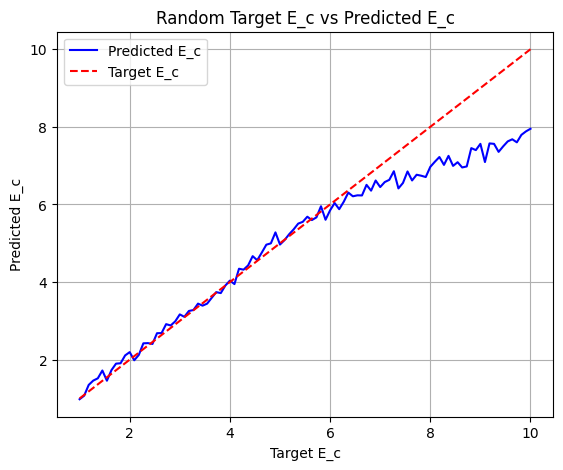

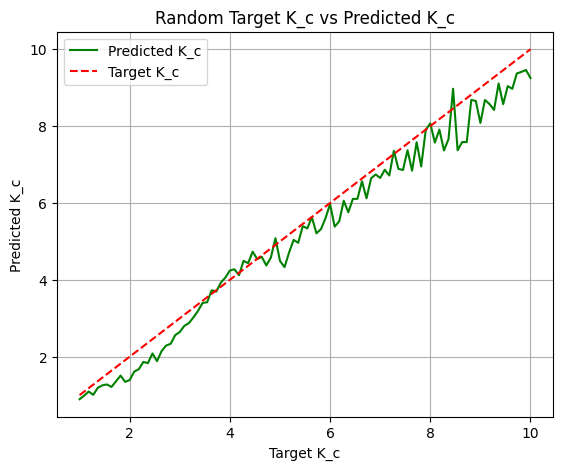

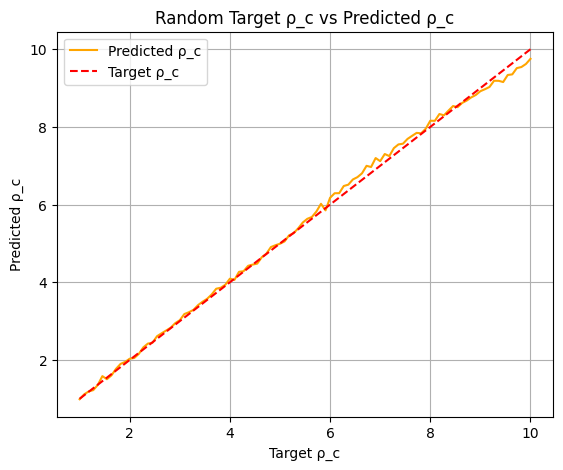

Sample Results:
Target: E_c=1.00, K_c=1.00, ρ_c=1.00
Predicted: E_c=0.98, K_c=0.89, ρ_c=0.99

Target: E_c=1.91, K_c=1.91, ρ_c=1.91
Predicted: E_c=2.11, K_c=1.34, ρ_c=1.95

Target: E_c=2.82, K_c=2.82, ρ_c=2.82
Predicted: E_c=2.88, K_c=2.34, ρ_c=2.83

Target: E_c=3.73, K_c=3.73, ρ_c=3.73
Predicted: E_c=3.74, K_c=3.69, ρ_c=3.83

Target: E_c=4.64, K_c=4.64, ρ_c=4.64
Predicted: E_c=4.76, K_c=4.60, ρ_c=4.64

Target: E_c=5.55, K_c=5.55, ρ_c=5.55
Predicted: E_c=5.68, K_c=5.34, ρ_c=5.63

Target: E_c=6.45, K_c=6.45, ρ_c=6.45
Predicted: E_c=6.21, K_c=6.10, ρ_c=6.65

Target: E_c=7.36, K_c=7.36, ρ_c=7.36
Predicted: E_c=6.41, K_c=6.89, ρ_c=7.55

Target: E_c=8.27, K_c=8.27, ρ_c=8.27
Predicted: E_c=7.02, K_c=7.37, ρ_c=8.30

Target: E_c=9.18, K_c=9.18, ρ_c=9.18
Predicted: E_c=7.57, K_c=8.57, ρ_c=9.03



In [ ]:
cvae.eval()
forward_net.eval()

if 'scaler_y' not in locals():
    scaler_y = StandardScaler().fit(Y_train)

n_samples = 100
e_c_targets = np.linspace(1, 10, n_samples)  
k_c_targets = np.linspace(1, 10, n_samples)   
rho_c_targets = np.linspace(1, 10, n_samples)  

predicted_ec_results = []
predicted_kc_results = []
predicted_rho_results = []

for e_c_target, k_c_target, rho_c_target in zip(e_c_targets, k_c_targets, rho_c_targets):
    y_target = np.array([[e_c_target, k_c_target, rho_c_target]])
    y_target_scaled = scaler_y.transform(y_target)

    latent_dim = 5
    z_random = torch.randn((10, latent_dim))  

    y_target_torch = torch.tensor(y_target_scaled, dtype=torch.float32)
    y_repeated = y_target_torch.repeat(z_random.size(0), 1)

    x_generated = cvae.decode(z_random, y_repeated)
    y_pred_scaled = forward_net(x_generated).detach().numpy()
    y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

    predicted_ec_results.append(np.mean(y_pred_unscaled[:, 0]))  
    predicted_kc_results.append(np.mean(y_pred_unscaled[:, 1]))  
    predicted_rho_results.append(np.mean(y_pred_unscaled[:, 2]))  

predicted_ec_results = np.array(predicted_ec_results)
predicted_kc_results = np.array(predicted_kc_results)
predicted_rho_results = np.array(predicted_rho_results)

plt.figure(figsize=(6.4, 5))
plt.plot(e_c_targets, predicted_ec_results, label='Predicted E_c', color='blue')
plt.plot(e_c_targets, e_c_targets, label='Target E_c', color='red', linestyle='--') 
plt.xlabel('Target E_c')
plt.ylabel('Predicted E_c')
plt.title('Random Target E_c vs Predicted E_c')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6.4, 5))
plt.plot(k_c_targets, predicted_kc_results, label='Predicted K_c', color='green')
plt.plot(k_c_targets, k_c_targets, label='Target K_c', color='red', linestyle='--')  
plt.xlabel('Target K_c')
plt.ylabel('Predicted K_c')
plt.title('Random Target K_c vs Predicted K_c')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6.4, 5))
plt.plot(rho_c_targets, predicted_rho_results, label='Predicted ρ_c', color='orange')
plt.plot(rho_c_targets, rho_c_targets, label='Target ρ_c', color='red', linestyle='--')  
plt.xlabel('Target ρ_c')
plt.ylabel('Predicted ρ_c')
plt.title('Random Target ρ_c vs Predicted ρ_c')
plt.legend()
plt.grid()
plt.show()

print("Sample Results:")
for i in range(0, len(e_c_targets), 10):  
    print(f"Target: E_c={e_c_targets[i]:.2f}, K_c={k_c_targets[i]:.2f}, ρ_c={rho_c_targets[i]:.2f}")
    print(f"Predicted: E_c={predicted_ec_results[i]:.2f}, K_c={predicted_kc_results[i]:.2f}, ρ_c={predicted_rho_results[i]:.2f}")
    print()

In [42]:
import pandas as pd

results_data = {
    "Target E_c": e_c_targets,
    "Predicted E_c": predicted_ec_results,
    "Target K_c": k_c_targets,
    "Predicted K_c": predicted_kc_results,
    "Target ρ_c": rho_c_targets,
    "Predicted ρ_c": predicted_rho_results
}

results_df = pd.DataFrame(results_data)

results_df.to_csv("target_vs_predicted.csv", index=False)


# Inverse Design without resctriction

In [20]:
cvae.eval()
forward_net.eval()

target_elastic_modulus = 3.0
target_thermal_conductivity = 5.0
target_density = 5.0

desired_target_raw = np.array([[target_elastic_modulus,
                                target_thermal_conductivity,
                                target_density]], dtype=np.float32)
desired_target_scaled = scaler_y.transform(desired_target_raw)
desired_target_torch = torch.tensor(desired_target_scaled, dtype=torch.float32)

n_samples = 5
candidate_features_list = []
candidate_pred_targets_list = []

with torch.no_grad():
    for i in range(n_samples):
        z_rand = torch.randn((1, cvae.latent_dim))
        x_gen_scaled = cvae.decode(z_rand, desired_target_torch)
        y_pred_scaled = forward_net(x_gen_scaled)
        x_gen_unscaled = scaler_x.inverse_transform(x_gen_scaled.numpy())
        y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled.numpy())
        
        candidate_features_list.append(x_gen_unscaled)
        candidate_pred_targets_list.append(y_pred_unscaled)

for i in range(n_samples):
    x_cand = candidate_features_list[i].flatten()      # (1,10)->(10,)
    y_cand_pred = candidate_pred_targets_list[i].flatten()  # (1,3)->(3,)
    print(f"Sample {i+1} / {n_samples}")
    for j, col_name in enumerate(feature_cols):
        print(f"    {col_name}: {x_cand[j]:.4f}")  
    print(f"  Predicted Target (Unscaled):\n    {y_cand_pred}")
    print(f"  Desired Target:\n    {desired_target_raw[0]}")

Sample 1 / 5
    matrix_elastic_modulus: 2.4604
    matrix_posson_ratio: 0.4678
    matrix_thermal_conductivity: 0.3127
    matrix_density: 1.4705
    solid_elastic_modulus: 147126.6875
    solid_posson_ratio: 0.2804
    solid_thermal_conductivity: 84.0317
    solid_density: 7.3338
    liquid_metal_fraction: 0.5034
    solid_fraction: 0.1812
  Predicted Target (Unscaled):
    [3.1083252 4.921762  4.921254 ]
  Desired Target:
    [3. 5. 5.]
Sample 2 / 5
    matrix_elastic_modulus: 2.6225
    matrix_posson_ratio: 0.4507
    matrix_thermal_conductivity: 0.2825
    matrix_density: 1.1921
    solid_elastic_modulus: 347912.0938
    solid_posson_ratio: 0.2497
    solid_thermal_conductivity: 457.9171
    solid_density: 11.2128
    liquid_metal_fraction: 0.5344
    solid_fraction: 0.1640
  Predicted Target (Unscaled):
    [3.0684006 5.0908313 5.539328 ]
  Desired Target:
    [3. 5. 5.]
Sample 3 / 5
    matrix_elastic_modulus: 1.2011
    matrix_posson_ratio: 0.4849
    matrix_thermal_conductivit

# With no restriction gradient descent

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

cvae.eval()
forward_net.eval()

target_elastic_modulus = 3.0
target_thermal_conductivity = 5.0
target_density = 5.0

desired_target_raw = np.array([[target_elastic_modulus,
                                target_thermal_conductivity,
                                target_density]], dtype=np.float32)
desired_target_scaled = scaler_y.transform(desired_target_raw)        # shape (1,3)
desired_target_torch = torch.tensor(desired_target_scaled, dtype=torch.float32)

z_opt = torch.randn((1, cvae.latent_dim), requires_grad=True)  
z_optimizer = optim.Adam([z_opt], lr=1e-2)                     
criterion_mse = nn.MSELoss()

n_steps = 200  

for step in range(n_steps):
    z_optimizer.zero_grad()
    x_gen_scaled = cvae.decode(z_opt, desired_target_torch)
    y_pred_scaled = forward_net(x_gen_scaled)
    loss_z = criterion_mse(y_pred_scaled, desired_target_torch)
    loss_z.backward()
    z_optimizer.step()
    if (step + 1) % 50 == 0:
        print(f"Step {step+1}, Loss={loss_z.item():.6f}")
x_gen_scaled_final = cvae.decode(z_opt, desired_target_torch)
y_pred_scaled_final = forward_net(x_gen_scaled_final)

x_gen_unscaled = scaler_x.inverse_transform(x_gen_scaled_final.detach().numpy())
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled_final.detach().numpy())

for j, col_name in enumerate(feature_cols):
    print(f"  {col_name}: {x_gen_unscaled[0, j]:.4f}")
print("\n  Predicted Target (Unscaled):", y_pred_unscaled[0])
print("  Desired Target            :", desired_target_raw[0])


Step 50, Loss=0.003367
Step 100, Loss=0.000809
Step 150, Loss=0.000570
Step 200, Loss=0.000565
  matrix_elastic_modulus: 1.7835
  matrix_posson_ratio: 0.4866
  matrix_thermal_conductivity: 0.2121
  matrix_density: 1.0367
  solid_elastic_modulus: 153710.8125
  solid_posson_ratio: 0.2774
  solid_thermal_conductivity: 96.1105
  solid_density: 6.6331
  liquid_metal_fraction: 0.5060
  solid_fraction: 0.2310

  Predicted Target (Unscaled): [3.0813644 5.0001545 4.973197 ]
  Desired Target            : [3. 5. 5.]


# Physics based meaning visulization

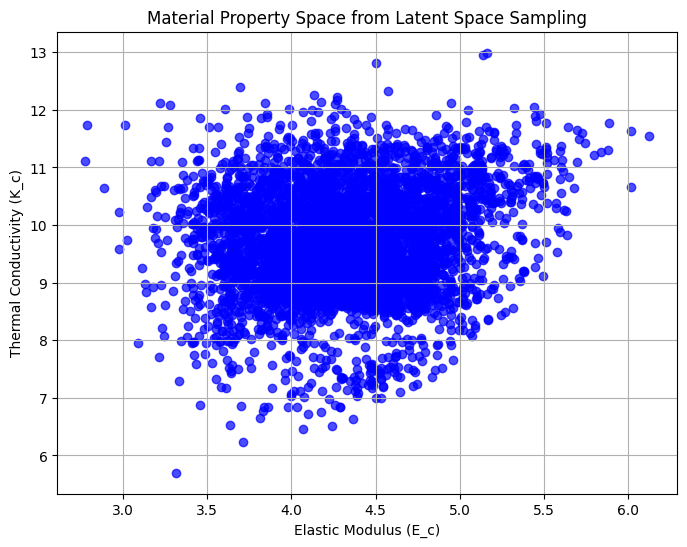

In [52]:
import matplotlib.pyplot as plt
import torch
import numpy as np

n_samples = 5000  
latent_dim = cvae.latent_dim  

z_samples = torch.randn((n_samples, latent_dim))

target_conditions = torch.tensor([[5.0, 10.0, 2.0]], dtype=torch.float32)
y_repeated = target_conditions.repeat(n_samples, 1)
x_generated = cvae.decode(z_samples, y_repeated).detach().numpy()


y_pred = forward_net(torch.tensor(x_generated, dtype=torch.float32)).detach().numpy()

ec_values = y_pred[:, 0]
kc_values = y_pred[:, 1] 

plt.figure(figsize=(8, 6))
plt.scatter(ec_values, kc_values, c='blue', alpha=0.7)
plt.xlabel('Elastic Modulus (E_c)')
plt.ylabel('Thermal Conductivity (K_c)')
plt.title('Material Property Space from Latent Space Sampling')
plt.grid()
plt.show()


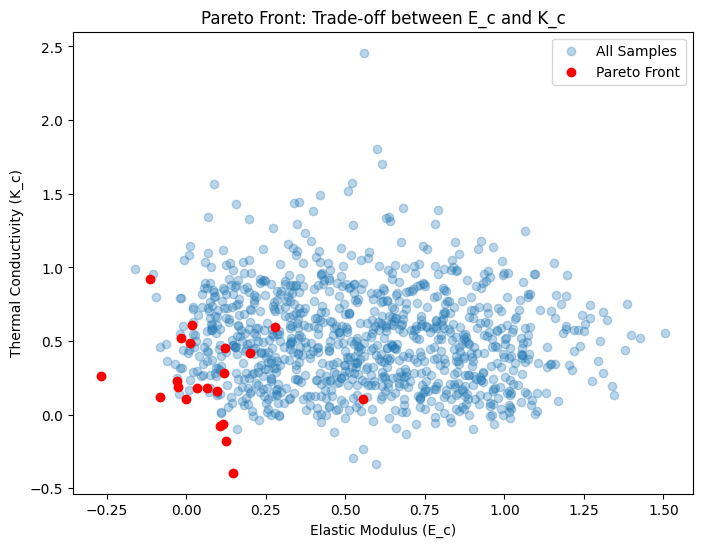

In [48]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

n_samples = 1000
latent_dim = cvae.latent_dim

z_samples = torch.randn((n_samples, latent_dim))
y_conditions = torch.tensor(np.random.uniform(0, 1, (n_samples, cvae.y_dim)), dtype=torch.float32)

x_generated = cvae.decode(z_samples, y_conditions).detach().numpy()

y_pred = forward_net(torch.tensor(x_generated, dtype=torch.float32)).detach().numpy()

sorting = NonDominatedSorting()
pareto_front_indices = sorting.do(y_pred, only_non_dominated_front=True)

pareto_front = y_pred[pareto_front_indices]

plt.figure(figsize=(8, 6))
plt.scatter(y_pred[:, 0], y_pred[:, 1], alpha=0.3, label='All Samples')
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color='red', label='Pareto Front')
plt.xlabel('Elastic Modulus (E_c)')
plt.ylabel('Thermal Conductivity (K_c)')
plt.title('Pareto Front: Trade-off between E_c and K_c')
plt.legend()
plt.show()
